In [1]:
import os

from pyment.data import NiftiDataset, AsyncNiftiGenerator
from pyment.data.preprocessors import NiftiPreprocessor

ixi_folder = os.path.join(os.path.expanduser('~'), 'data', 'IXI', 'cropped')
dataset = NiftiDataset.from_folder(ixi_folder, target='age')
preprocessor = NiftiPreprocessor(sigma=255.)
generator = AsyncNiftiGenerator(
    dataset=dataset,
    preprocessor=preprocessor,
    batch_size=4,
    threads=8
)

2022-03-25 14:08:43,848 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI638-HH-2786-T1: Missing labels
2022-03-25 14:08:43,848 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI347-IOP-0927-T1: Missing labels
2022-03-25 14:08:43,849 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI661-HH-2788-T1: Missing labels
2022-03-25 14:08:43,849 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI643-HH-2787-T1: Missing labels
2022-03-25 14:08:43,849 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI088-Guys-0758-T1: Missing labels
2022-03-25 14:08:43,850 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI589-Guys-1080-T1: Missing labels
2022-03-25 14:08:43,850 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI341-Guys-0906-T1: Missing labels
2022-03-25 14:08:43,850 - WARNING - pyment.data.datasets.nifti_dataset: Skipping IXI337-IOP-0929-T1: Missing labels
2022-03-25 14:08:43,851 - WARNING - pyment.data.datasets.nifti_dataset: 

In [2]:
from pyment.models import RegressionSFCN

model = RegressionSFCN(weights='brain-age')

predictions = model.predict(generator)

2022-03-25 14:08:43.944688: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 14:08:43.951760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 14:08:43.951947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 14:08:43.952496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(None, 1)
3


  0%|                                                                                                                               | 0/135 [00:00<?, ?it/s]2022-03-25 14:08:45.261905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-25 14:08:45.752535: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-03-25 14:08:45.965060: W tensorflow/stream_executor/gpu/asm_compiler.cc:113] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:06<00:00,  2.02it/s]


In [3]:
import numpy as np


ages = dataset.y
predictions = predictions.squeeze()
predictions = predictions[np.where(~np.isnan(ages))]
ages = ages[np.where(~np.isnan(ages))]
delta = predictions - ages
print(f'Brain age delta: {round(np.mean(np.abs(delta)), 2)}')

Brain age delta: 4.0


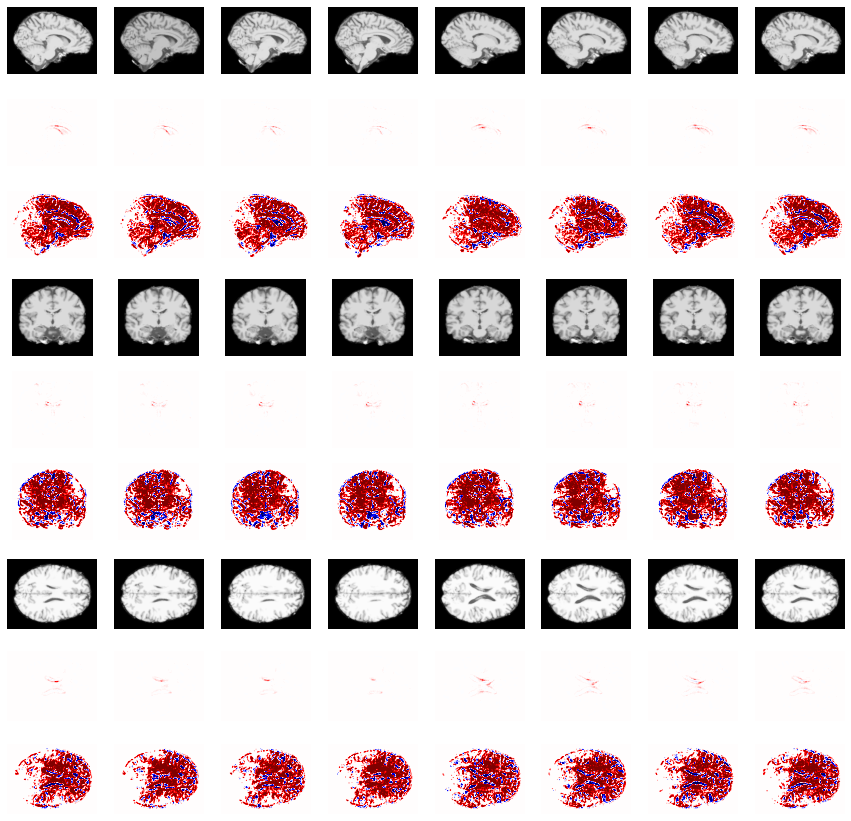

In [37]:
import matplotlib.pyplot as plt

from explainability import LRP, LRPStrategy

alpha=2
beta=1

strategy = LRPStrategy(
    layers=[
        {'alpha': 1, 'beta': 0},
        {'alpha': alpha, 'beta': beta},
        {'alpha': alpha, 'beta': beta},
        {'alpha': alpha, 'beta': beta},
        {'alpha': alpha, 'beta': beta},
        {'alpha': alpha, 'beta': beta},
        {'epsilon': 0.25}
    ])

lrp = LRP(model, layer=len(model.layers)-1, idx=0, strategy=strategy)

for X, y in generator:
    preds = model.predict(X)
    explanations = lrp(X[:1])[0].numpy()
    explanations = explanations / np.amax(np.abs(explanations))
    mask = np.zeros_like(explanations)
    positive = explanations[np.where(explanations > 0)]
    positive = np.median(positive)
    negative = explanations[np.where(explanations < 0)]
    negative = np.median(negative)
    mask[np.where(explanations > positive)] = 1
    mask[np.where(explanations < negative)] = -1
    idx = np.argmax(explanations)
    idx = np.unravel_index(idx, explanations.shape)
    
    fig, ax = plt.subplots(9, 8, figsize=(15, 15))
    
    for i in range(-4, 4):
        ax[0][i].imshow(np.rot90(X[0,idx[0]+i]), cmap='Greys_r')
        ax[0][i].axis('off')
        ax[1][i].imshow(np.rot90(explanations[idx[0]+i]), cmap='seismic', clim=(-1, 1))
        ax[1][i].axis('off')
        ax[2][i].imshow(np.rot90(mask[idx[0]+i]), cmap='seismic', clim=(-1, 1))
        ax[2][i].axis('off')
        ax[3][i].imshow(np.rot90(X[0,:,idx[1]+i]), cmap='Greys_r')
        ax[3][i].axis('off')
        ax[4][i].imshow(np.rot90(explanations[:,idx[1]+i]), cmap='seismic', clim=(-1, 1))
        ax[4][i].axis('off')
        ax[5][i].imshow(np.rot90(mask[:,idx[1]+i]), cmap='seismic', clim=(-1, 1))
        ax[5][i].axis('off')
        ax[6][i].imshow(X[0,:,:,idx[2]+i], cmap='Greys_r')
        ax[6][i].axis('off')
        ax[7][i].imshow(explanations[:,:,idx[2]+i], cmap='seismic', clim=(-1, 1))
        ax[7][i].axis('off')
        ax[8][i].imshow(mask[:,:,idx[2]+i], cmap='seismic', clim=(-1, 1))
        ax[8][i].axis('off')
        
    break

    plt.show()

In [47]:
[-4*(30/40), 7*(30/40), 0, -17*(30/40), 44*(30/40)]

[-3.0, 5.25, 0, -12.75, 33.0]